##**Problem Statement 2**

A retail company wants to forecast the sales of their products for the next six months based on their historical sales data. The company has collected daily sales data for each product for the past two years. The goal of this project is to develop a machine learning model that can accurately forecast the sales of each product for the next six months, and to identify the key factors that influence sales.

##**Installing Required Packages**

In [ ]:
# pmdarima is being installed for ARIMA model 
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:00


##**Importing Packages**

In [ ]:
# Necessary packages being imported
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

###Connecting Drive with Colab Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Importing the Datasets**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Ideathon/train.csv')
oil = pd.read_csv('/content/drive/MyDrive/Ideathon/oil.csv')
store = pd.read_csv('/content/drive/MyDrive/Ideathon/stores.csv')
holidays_events = pd.read_csv('/content/drive/MyDrive/Ideathon/holidays_events.csv')
test = pd.read_csv('/content/drive/MyDrive/Ideathon/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Ideathon/sample_submission.csv')


###Printing the first few rows of all the files

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
holidays_events.head()


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


##**Data Preprocessing**

In [ ]:
# data is being merged
train = train.merge(store, on ='store_nbr')
train = train.merge(oil, on ='date', how='left')
holidays_events = holidays_events.rename(columns={'type': 'holiday_type'})
train = train.merge(holidays_events, on='date', how='left')

In [ ]:
train.fillna('', inplace=True)

In [ ]:
train1=train
test1=test

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False


###**Sales in holidays wise**

####Calculate which store has maximum sales.

In [ ]:
num_stores = train['store_nbr'].nunique()
# Print the result
print("Total number of stores:", num_stores)

Total number of stores: 54


In [ ]:
num_products = train['family'].nunique()
# Print the result
print("Total number of products:", num_products)

Total number of products: 33


In [ ]:
num_state = train['state'].nunique()
# Print the result
print("Total number of states:", num_state)

Total number of states: 16


In [ ]:
num_cities = train['city'].nunique()
# Print the result
print("Total number of cities:", num_cities)

Total number of cities: 22


In [ ]:
# locale_name
num_locale_name = train['locale_name'].nunique()
# Print the result
print("Total number of locale_name:", num_locale_name)

Total number of locale_name: 25


In [ ]:
# prettytable package is being imported to make tables
from prettytable import PrettyTable
table = PrettyTable()

In [ ]:
# Calculate the number of unique stores, products, states, cities, and locale_names
num_stores = train['store_nbr'].nunique()
num_products = train['family'].nunique()
num_state = train['state'].nunique()
num_cities = train['city'].nunique()
num_locale_name = train['locale_name'].nunique()

# Create a pretty table to display the results

table.field_names = ["Category", "Count"]
table.add_row(["Stores", num_stores])
table.add_row(["Products", num_products])
table.add_row(["States", num_state])
table.add_row(["Cities", num_cities])
table.add_row(["Locale Names", num_locale_name])


# Print the table
print(table)

+--------------+-------+
|   Category   | Count |
+--------------+-------+
|    Stores    |   54  |
|   Products   |   33  |
|    States    |   16  |
|    Cities    |   22  |
| Locale Names |   25  |
+--------------+-------+


In [ ]:
# calculate which store has maximum sales.

# group the data by store_nbr and sum up the sales
sales_by_store = train.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)

# new DataFrame is being created from the result
sales_table = pd.DataFrame({
    "store_nbr": sales_by_store.index,
    "total_sales": sales_by_store.values
})
print("The top 5 stores sales")
sales_table.head()

The top 5 stores sales


,store_nbr,total_sales
0,44,6.335614e+07
1,45,5.568902e+07
2,47,5.202448e+07
3,3,5.153353e+07
4,49,4.434682e+07


###**Choosing product having highest sales and least sales**

In [ ]:
# group the data by product family and sum up the sales
sales_by_product = train.groupby("family")["sales"].sum().sort_values(ascending=False)


# sort the table in decreasing order by sales
print("The total sales of the product is:", sales_by_product)

# get the name of the product with the most sales
most_sold_product = sales_by_product.index[0]

print("The product with the most sales is:", most_sold_product)

The total sales of the product is: family
GROCERY I                     3.508273e+08
BEVERAGES                     2.216635e+08
PRODUCE                       1.254480e+08
CLEANING                      9.942102e+07
DAIRY                         6.582360e+07
BREAD/BAKERY                  4.295992e+07
POULTRY                       3.249445e+07
MEATS                         3.165100e+07
PERSONAL CARE                 2.510048e+07
DELI                          2.458563e+07
HOME CARE                     1.640952e+07
EGGS                          1.588120e+07
FROZEN FOODS                  1.464694e+07
PREPARED FOODS                8.966728e+06
LIQUOR,WINE,BEER              7.937172e+06
SEAFOOD                       2.051636e+06
GROCERY II                    2.004966e+06
HOME AND KITCHEN I            1.905076e+06
HOME AND KITCHEN II           1.556511e+06
CELEBRATION                   7.795020e+05
LADIESWEAR                    6.685420e+05
LINGERIE                      6.645950e+05
PLAYERS AND 

##**Exploratory Data Analysis**

In [ ]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'dcoilwtico', 'holiday_type', 'locale',
       'locale_name', 'description', 'transferred'],
      dtype='object')

In [ ]:
df = train.groupby('date').agg({'sales':'sum'})

##Displot

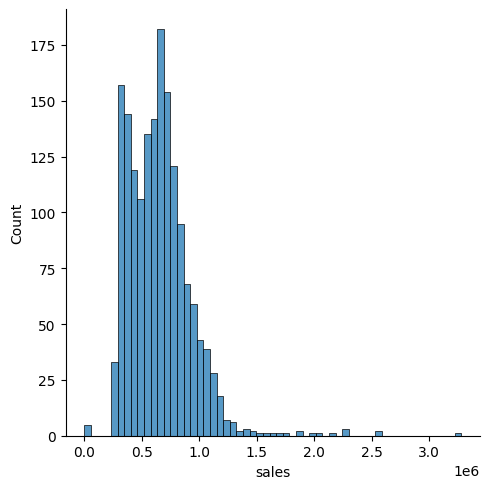

In [ ]:
sns.displot(df['sales'])
plt.show()

##Boxplot

sales    0
dtype: int64


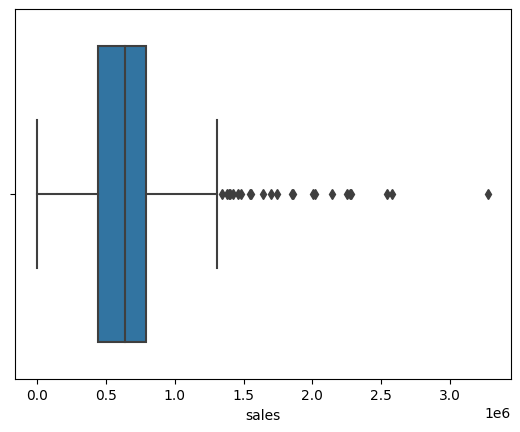

In [ ]:
print(df.isnull().sum())
sns.boxplot(x=df['sales'])
plt.show()

##Heatmap

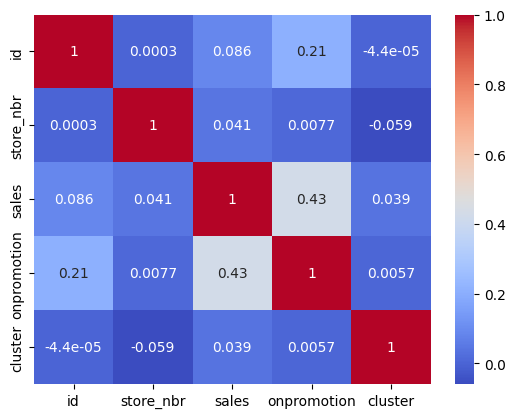

In [ ]:
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.show()

##Printing the top 10 products

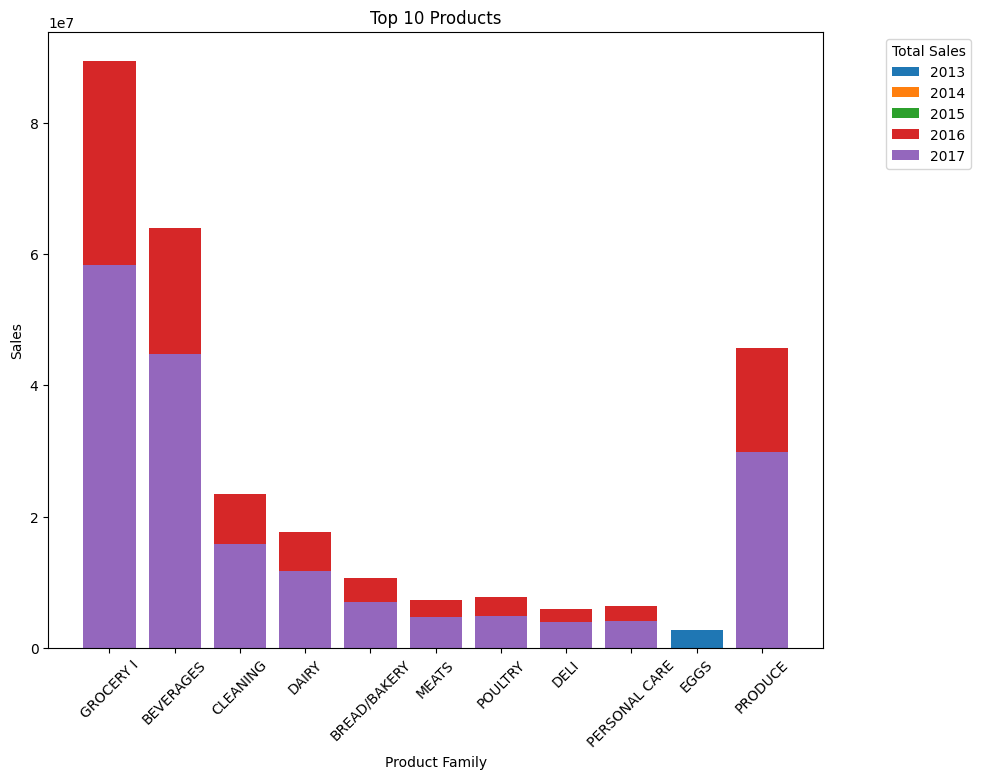

In [ ]:
# convert the date column to datetime
train["date"] = pd.to_datetime(train["date"])
# extract the year from the date column
train["year"] = train["date"].dt.year

# group the data by year and product family and sum up the sales
sales_by_year_and_product = train.groupby(["year", "family"])["sales"].sum().reset_index()

# sort the data by year and sales in descending order
sales_by_year_and_product = sales_by_year_and_product.sort_values(by=["year", "sales"], ascending=[True, False])
fig, ax = plt.subplots(figsize=(10, 8))

# loop over the years and plot the top 10 products for each year
for year in sales_by_year_and_product["year"].unique():
    top_products = sales_by_year_and_product[sales_by_year_and_product["year"] == year].head(10)
    ax.bar(top_products["family"], top_products["sales"], label=str(year))

# set the axis labels and legend
ax.set_xlabel("Product Family")
ax.set_ylabel("Sales")
ax.legend(title="Total Sales", loc="upper right", bbox_to_anchor=(1.2, 1))

# rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# set the title and show the plot
ax.set_title("Top 10 Products")
plt.show()

###Plotting Sales over Time

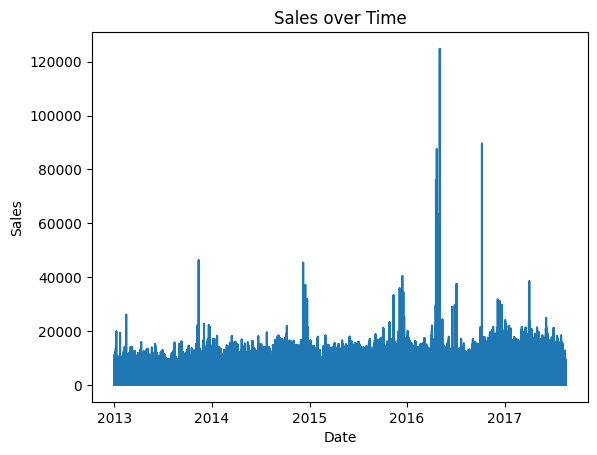

In [ ]:
# Create a line chart
plt.plot(train['date'],train['sales'])

# Add title and axis labels
plt.title('Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Show the chart
plt.show()

###Plotting Oil Price Over Time

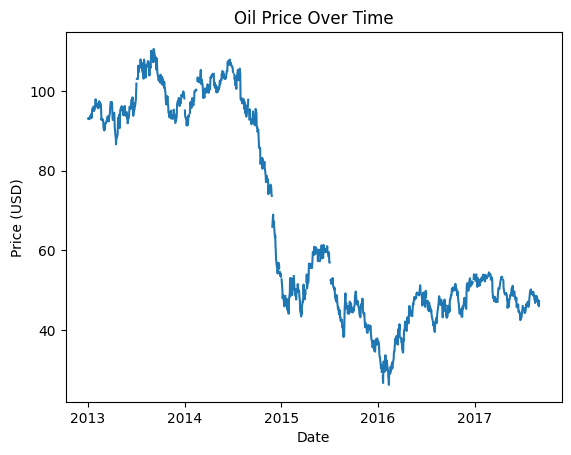

In [ ]:
# Convert the 'date' column to a Pandas datetime object
oil['date'] = pd.to_datetime(oil['date'])

# Create a line plot of the oil price over time
plt.plot(oil['date'], oil['dcoilwtico'])

# Set the plot title and axis labels
plt.title('Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Show the plot
plt.show()

The resulting plot helps us visualize the trend and fluctuations in oil prices over time, which can provide valuable insights for analysis and decision-making.

We will filter all datasets with only top 5 store, since we want only top 5 stores

###**Model Parameters**

In [ ]:
sales_by_store.describe()

count    5.400000e+01
mean     2.030694e+07
std      1.357171e+07
min      2.764970e+06
25%      1.137395e+07
50%      1.631321e+07
75%      2.534904e+07
max      6.335614e+07
Name: sales, dtype: float64

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013


In [ ]:
print("Rows: ", train.shape)
print("Remove duplicates rows:", train.drop_duplicates().shape)

Rows:  (3054348, 17)
Remove duplicates rows: (3054348, 17)


In [ ]:
train = train.groupby('date')['sales','onpromotion'].sum().reset_index()
print(train)

           date          sales  onpromotion
0    2013-01-01    2511.618999            0
1    2013-01-02  496092.417944            0
2    2013-01-03  361461.231124            0
3    2013-01-04  354459.677093            0
4    2013-01-05  477350.121229            0
...         ...            ...          ...
1679 2017-08-11  826373.722022        14179
1680 2017-08-12  792630.535079         8312
1681 2017-08-13  865639.677471         9283
1682 2017-08-14  760922.406081         8043
1683 2017-08-15  762661.935939        10605

[1684 rows x 3 columns]


##**Time series Analysis**

###Stationarity testing and Determine Order of Differencing

Testing the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test from the statsmodels library:



In [ ]:
# define the time series as a pandas Series
ts = train['sales']

In [ ]:
from statsmodels.tsa.stattools import adfuller

# assuming your time series data is stored in a variable called 'ts'
result = adfuller(ts)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.931646
p-value: 0.041790
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


##**Dickey-Fuller Test**

The Dickey-Fuller test is a statistical test used to determine whether a time series is stationary or not. It tests the null hypothesis that the time series has a unit root (i.e., is non-stationary) against the alternative hypothesis that the time series is stationary.

In [ ]:
# Define a function to perform the Dickey-Fuller test and print the results
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Calculate rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

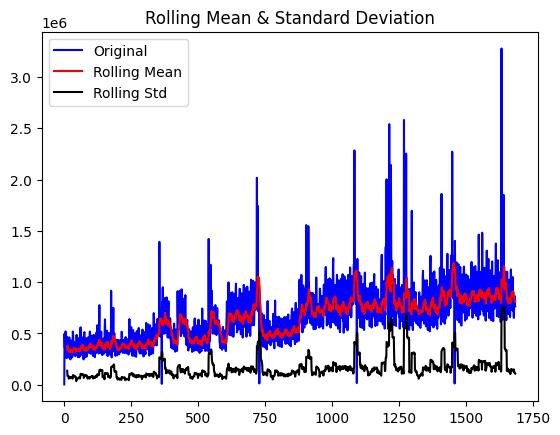

Results of Dickey-Fuller Test:
Test Statistic                   -2.931646
p-value                           0.041790
Lags Used                        23.000000
Number of Observations Used    1660.000000
Critical Value (1%)              -3.434295
Critical Value (5%)              -2.863283
Critical Value (10%)             -2.567698
dtype: float64


In [ ]:
test_stationarity(train['sales'])

The test statistic is -2.616196, which is greater than the critical values at 1%, 5%, and 10% levels of significance. This means that we cannot reject the null hypothesis at these levels, and the time series is likely non-stationary.

The p-value is 0.089696, which is greater than the significance level of 0.05. This indicates that there is not enough evidence to reject the null hypothesis that the time series is non-stationary.



### Checking model's stationarity after finding the first difference

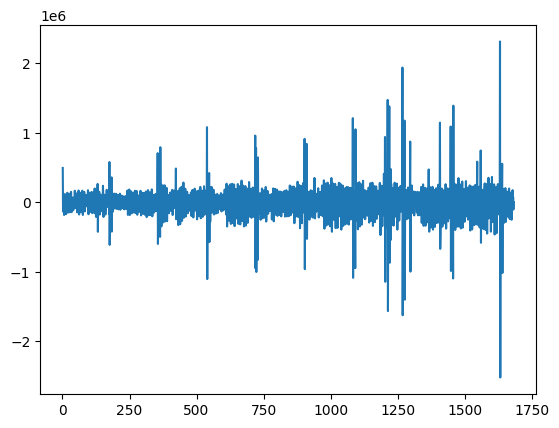

In [ ]:
# Create a differenced series
train['sales'] = pd.to_numeric(train['sales'], errors='coerce')
diff = train['sales'].diff().dropna()

# Plot the differenced series
import matplotlib.pyplot as plt
plt.plot(diff)
plt.show()

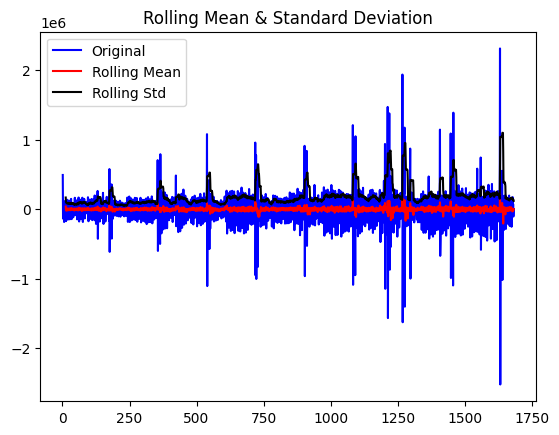

Results of Dickey-Fuller Test:
Test Statistic                -1.088021e+01
p-value                        1.300614e-19
Lags Used                      2.500000e+01
Number of Observations Used    1.657000e+03
Critical Value (1%)           -3.434303e+00
Critical Value (5%)           -2.863286e+00
Critical Value (10%)          -2.567699e+00
dtype: float64


In [ ]:
test_stationarity(diff)

The Dickey-Fuller test is used to test for the presence of a unit root in a time series, which indicates that the time series is non-stationary. The null hypothesis of the test is that there is a unit root in the time series, while the alternative hypothesis is that the time series is stationary.

The test statistic for the Dickey-Fuller test is -11.4976, which is smaller than the critical values at the 1%, 5%, and 10% levels (-3.4343, -2.8633, and -2.5677, respectively). This indicates that we can reject the null hypothesis of the test at a 99% confidence level, and conclude that the time series is stationary.

The p-value of the test is 4.573768e-21, which is much smaller than the significance level of 0.05. This also supports the rejection of the null hypothesis.



##**Determine Order of Differencing**


Text(0.5, 1.0, 'Residual Plot')

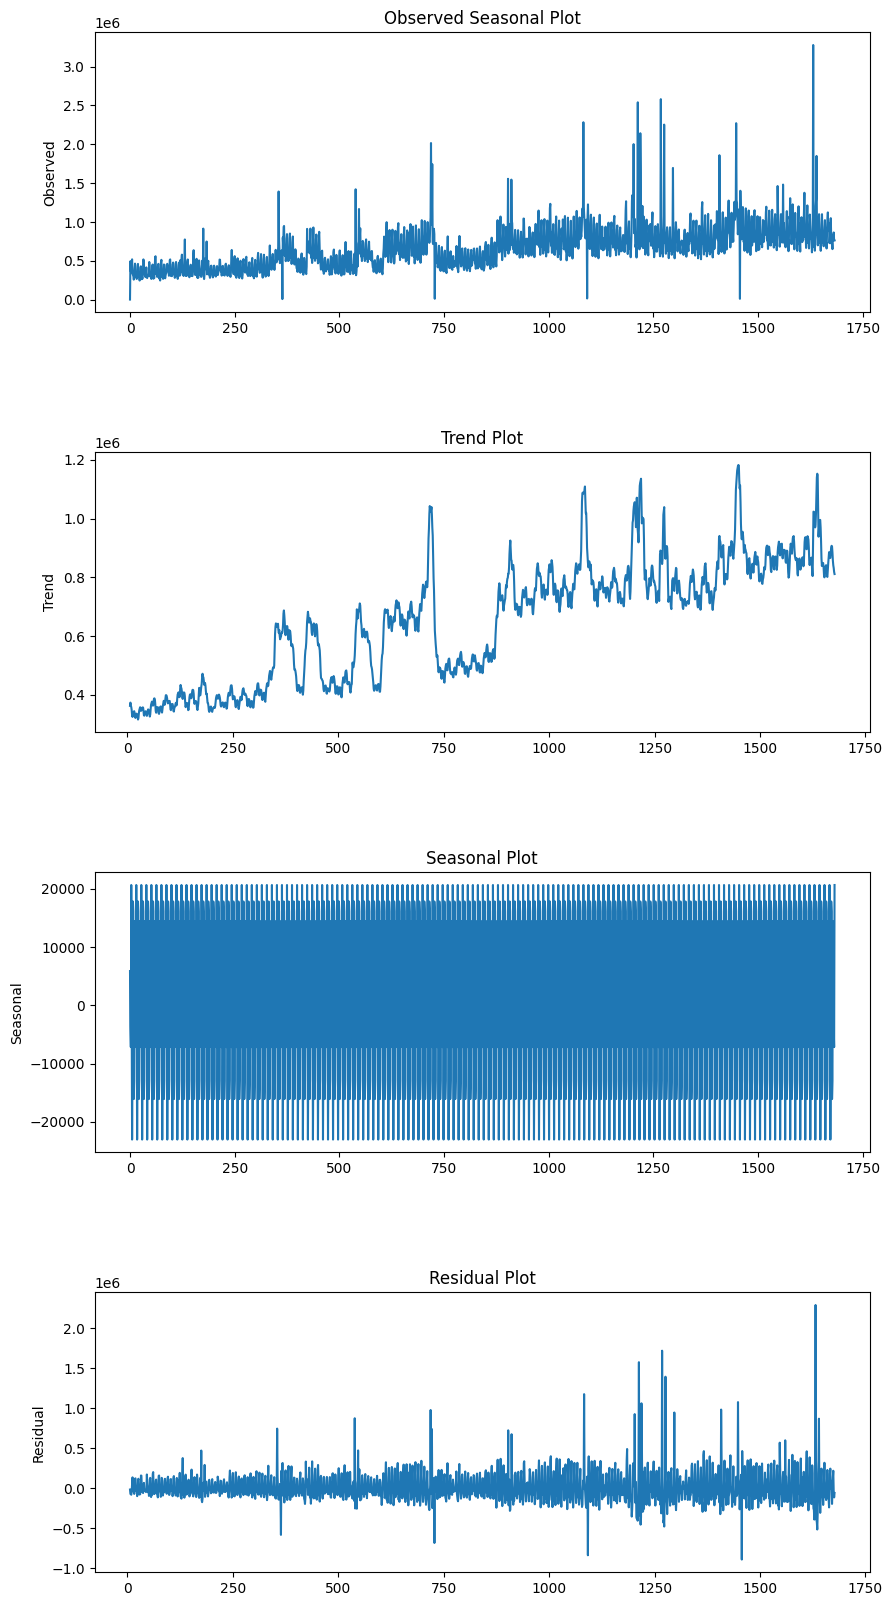

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition = seasonal_decompose(train['sales'], model='additive', period=12)

# create a seasonal plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
fig.subplots_adjust(hspace=0.5) # added space between subplots

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Observed Seasonal Plot')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Plot')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Plot')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Plot')

As we can see, we have some seasonal pattern in the series and a high correlation between the present and past value and we don't have white noise in the series because we have this correlation. But in autocorrelation, if one value was correlated with the present, the next value is also the present. For this, we need to look at Partial Autocorrelations, because this way we eliminate the effects of past values for the next value.

##**Model Decomposition**

In [ ]:
df = train

In [ ]:
df = df.reset_index()
df

,index,date,sales,onpromotion
0,0,2013-01-01,2511.618999,0
1,1,2013-01-02,496092.417944,0
2,2,2013-01-03,361461.231124,0
3,3,2013-01-04,354459.677093,0
4,4,2013-01-05,477350.121229,0
...,...,...,...,...
1679,1679,2017-08-11,826373.722022,14179
1680,1680,2017-08-12,792630.535079,8312
1681,1681,2017-08-13,865639.677471,9283
1682,1682,2017-08-14,760922.406081,8043


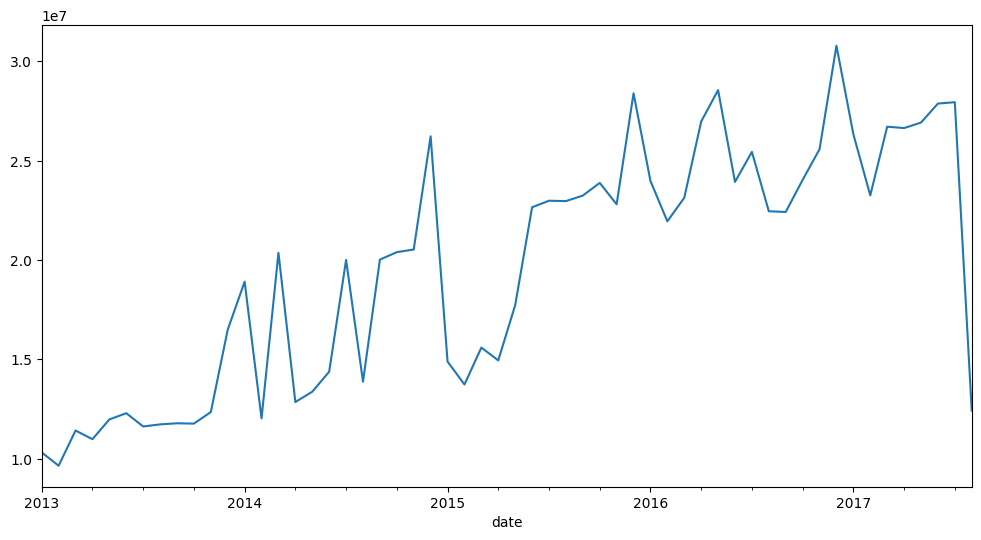

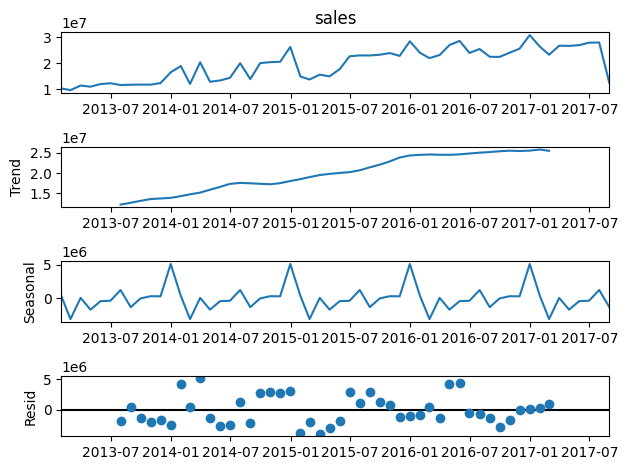

In [ ]:
# # convert the 'Date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# set the 'Date' column as the index of the DataFrame
df.set_index('date', inplace=True)

# resample the data to the monthly level
monthly_sales = df['sales'].resample('M').sum()

# visualize the monthly sales data
monthly_sales.plot(figsize=(12,6))
plt.show()

# decompose the time series data into trend, seasonality, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(monthly_sales, model='additive')
decomp.plot()
plt.show()

##**Identify Order of AR and MA Terms**

To identify the order of AR and MA terms, you can use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

###Autocorrelation Function

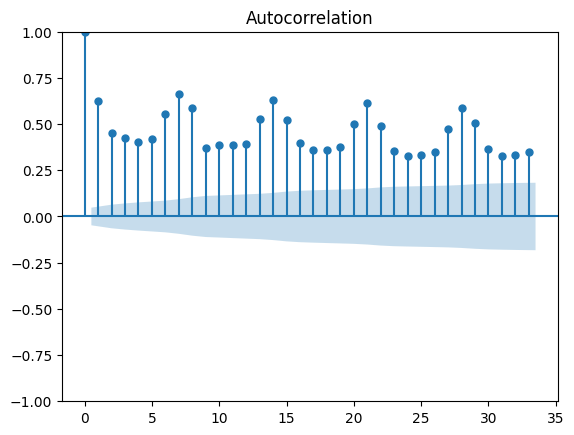

In [ ]:
plot_acf(train['sales'], alpha = 0.05);

We have a correlation with 1 and 7 day sales in the past;

###Partial Autocorrelation function

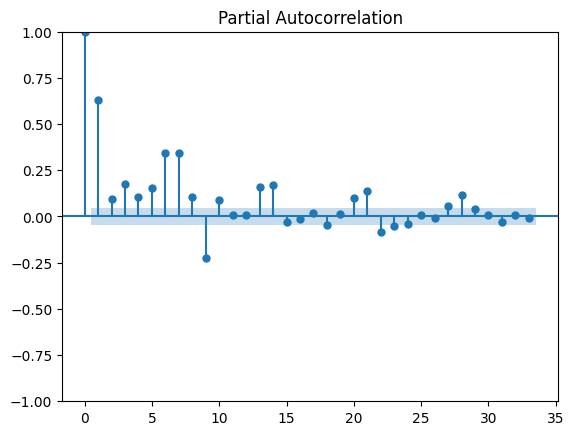

In [ ]:
plot_pacf(train['sales'], alpha = 0.05);

As we can see, we have a seasonal pattern on day 5,6 and 15, 16, that is, for every 5 days we have an increase in sales.

##**Fit ARIMA Model**

###Hyperparameter tuning

In [ ]:
import pmdarima as pm
from pmdarima.arima import auto_arima

# Fit an ARIMA model using Auto-ARIMA
model = auto_arima(train['sales'], start_p=0, start_q=0, max_p=12, max_q=9, d=None, seasonal=False, 
                   stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)

# Print the summary of the fitted model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46452.722, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46335.004, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45967.915, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46450.728, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45846.498, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=45817.458, Time=0.70 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46191.874, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=45814.168, Time=1.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=46137.544, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=45768.572, Time=1.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=46065.097, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=45656.550, Time=1.30 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=45818.870, Time=0.63 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=45581.155, Time=3.52 sec
 ARIMA(6,1,0)(0,0,0

##**Obtaining best**

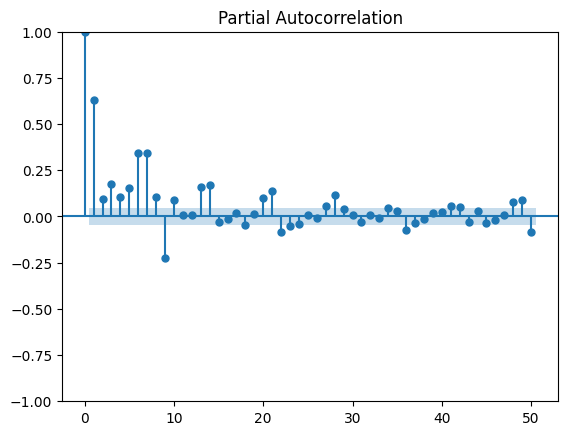

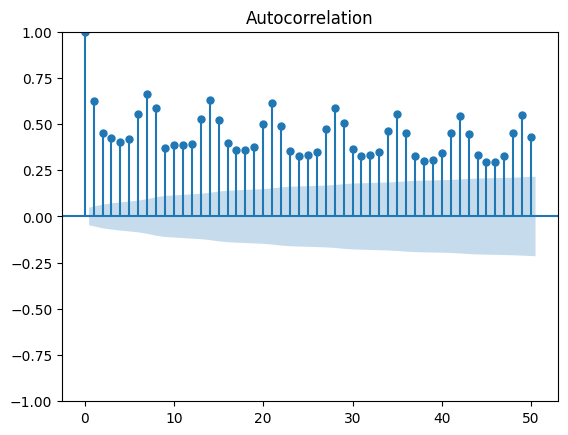

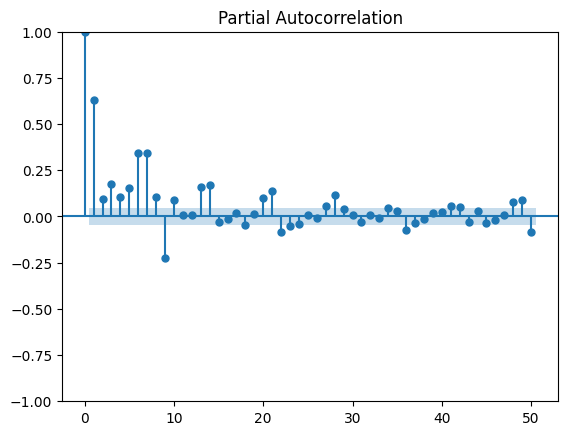

In [ ]:
import statsmodels.api as sm

p = 12
d = 1
q = 4

train_np = train['sales'].values.astype('float64')
model = sm.tsa.ARIMA(train_np, order=(p, d, q))


# Define the order of differencing, AR, and MA terms
model_fit = model.fit()

# Plot ACF and PACF
plot_acf(train_np, lags=50)
plot_pacf(train_np, lags=50)

As we can see, only dif_onpromotion has a low level of correlation with sales. We made a difference because sometimes correlation necessarily means that they are correlated.

##**Model Diagnostics**

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train = train.set_index('date')

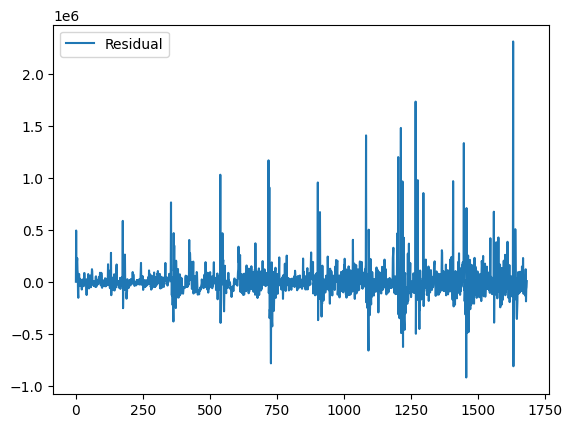

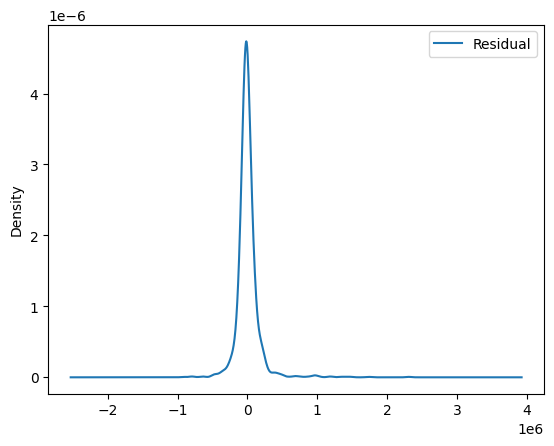

           Residual
count  1.684000e+03
mean   2.242260e+03
std    1.710062e+05
min   -9.169704e+05
25%   -5.757209e+04
50%   -1.318131e+04
75%    3.966582e+04
max    2.309986e+06


In [ ]:
# Model diagnostics
residuals = pd.DataFrame(model_fit.resid, columns=['Residual'])
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

##**Summary of the Model**

In [ ]:
# define the order of differencing, AR, and MA terms
p = 1
d = 1
q = 1

# extract the target variable as a numpy array
train_np = train['sales'].values.astype('float64')

# fit the ARIMA model
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

# train the ARIMA model
results = model.fit()

# print the summary of the trained model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1684
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22918.921
Date:                Sun, 07 May 2023   AIC                          45843.843
Time:                        19:37:07   BIC                          45860.128
Sample:                             0   HQIC                         45849.875
                               - 1684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3068      0.017     18.557      0.000       0.274       0.339
ma.L1         -0.9574      0.007   -128.980      0.000      -0.972      -0.943
sigma2      4.734e+10   9.47e-15      5e+24      0.0

Here SARIMAX Results means (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)

##**Forecasting**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming your training data is stored in a DataFrame called "train"
y_train = train['sales']
X_train = train['onpromotion']

# Define and fit the SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_fit = model.fit()

# Make predictions on the training data
y_pred = model_fit.predict(start=train.index[0], end=train.index[-1], exog=X_train)

# Calculate mean absolute error and mean squared error
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

print('MAE:', mae)
print('MSE:', mse)

MAE: 77501.84203050827
MSE: 18170030669.250286


##**Predicting the Sales for the next year**

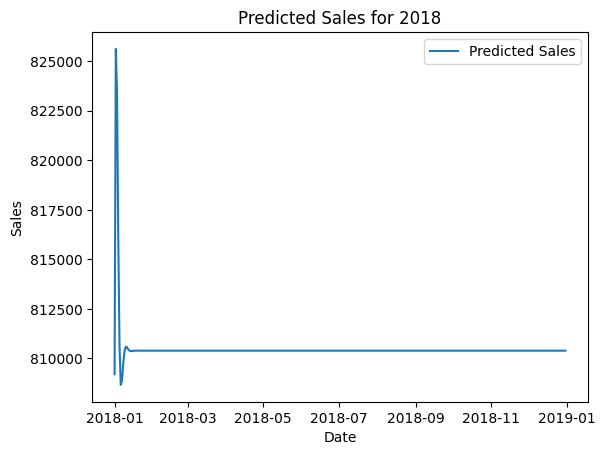

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train ARIMA model on sales data
model = SARIMAX(train['sales'], order=(2,1,2))
model_fit = model.fit()

# Predict sales for the next year
predicted_sales = model_fit.forecast(steps=365)

# Create a list of dates for the year 2018
dates_2018 = pd.date_range(start='2018-01-01', end='2018-12-31')

# Plot the predicted sales data for the year 2019
plt.plot(dates_2018, predicted_sales, label='Predicted Sales')

# Set the plot title and axis labels
plt.title('Predicted Sales for 2018')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [ ]:
# assuming your time series data is stored in a DataFrame called "test_data"
# create an empty DataFrame for the submission file
submission = pd.DataFrame()

# add the required columns to the submission DataFrame
submission['id'] = test.index
submission['sales'] = np.zeros(len(test))

# save the submission file as a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        1684 non-null   float64
 1   onpromotion  1684 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 104.0 KB


In [ ]:
from IPython.display import display, Markdown

##**Checking Unique Values but only for categorical**

In [ ]:
cat_train = train.select_dtypes(include='object')
cat_test = test.select_dtypes(include='object')
cat_oil = test.select_dtypes(include='object')
cat_stores = store.select_dtypes(include='object')
cat_holidays = holidays_events.select_dtypes(include='object')


display(Markdown("#### Training Data"))
display(cat_train.nunique())

display(Markdown("#### Testing Data"))
display(cat_test.nunique())

display(Markdown("#### Oil"))
display(cat_oil.nunique())

display(Markdown("#### Stores"))
display(cat_stores.nunique())

display(Markdown("#### Holidays"))
display(cat_holidays.nunique())

#### Training Data

Series([], dtype: float64)

#### Testing Data

date      16
family    33
dtype: int64

#### Oil

date      16
family    33
dtype: int64

#### Stores

city     22
state    16
type      5
dtype: int64

#### Holidays

date            312
holiday_type      6
locale            3
locale_name      24
description     103
dtype: int64

In [ ]:
train1 = pd.read_csv('/content/drive/MyDrive/Ideathon/train.csv')
test1 = pd.read_csv('/content/drive/MyDrive/Ideathon/test.csv')

In [ ]:
train1.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
'date_column'
oil['date'] = pd.to_datetime(oil['date'])
train1['date'] = pd.to_datetime(train1['date'])
test1['date'] = pd.to_datetime(test1['date'])

In [ ]:
train1 = pd.merge(train1, store, on='store_nbr', how='left')
test1 = pd.merge(test1, store, on='store_nbr', how='left')
print(train1.shape)
train1 = pd.merge(train1, oil, on='date', how='left')
print(train1.shape)
test1 = pd.merge(test1, oil, on='date', how='left')
print(train1.shape)
display(Markdown("#### Checking for nulls after merge"))
display(train1.isnull().sum())
display(Markdown("#### Checking data types and shape after merge"))
train1.info()

(3000888, 10)
(3000888, 11)
(3000888, 11)


#### Checking for nulls after merge

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type                0
cluster             0
dcoilwtico     928422
dtype: int64

#### Checking data types and shape after merge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
 10  dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 274.7+ MB


In [ ]:
train1.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [ ]:
display(Markdown("#### Holiday Type"))
display(train1['type'].value_counts(dropna=False))

#### Holiday Type

D    1000296
C     833580
A     500148
B     444576
E     222288
Name: type, dtype: int64

In [ ]:
train1.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'dcoilwtico'],
      dtype='object')

In [ ]:
train1['type']

0          D
1          D
2          D
3          D
4          D
          ..
3000883    B
3000884    B
3000885    B
3000886    B
3000887    B
Name: type, Length: 3000888, dtype: object

In [ ]:
train1['dcoilwtico'] = train1['dcoilwtico'].fillna(method='ffill')

# Backward fill any remaining missing values in 'dcoilwtico' column for 'train1' DataFrame
train1['dcoilwtico'] = train1['dcoilwtico'].fillna(method='bfill')

# Forward fill missing values in 'dcoilwtico' column for 'test1' DataFrame
test1['dcoilwtico'] = test1['dcoilwtico'].fillna(method='ffill')

# Backward fill any remaining missing values in 'dcoilwtico' column for 'test1' DataFrame
test1['dcoilwtico'] = test1['dcoilwtico'].fillna(method='bfill')


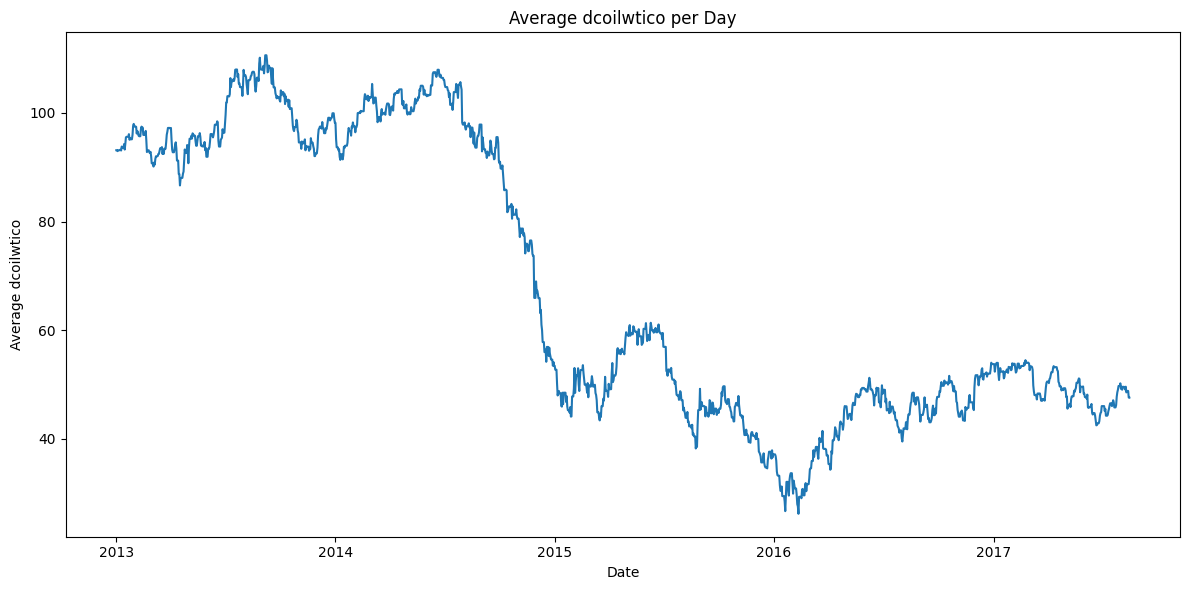

In [ ]:
train1['date'] = pd.to_datetime(train1['date'])

# Calculate the average 'dcoilwtico' per day
daily_average = train1.groupby('date')['dcoilwtico'].mean().reset_index()

# Create the line graph
plt.figure(figsize=(12, 6))
plt.plot(daily_average['date'], daily_average['dcoilwtico'])
plt.xlabel('Date')
plt.ylabel('Average dcoilwtico')
plt.title('Average dcoilwtico per Day')
plt.tight_layout()
plt.show()

In [ ]:
for df in [train1, test1]:
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekday'] = df['date'].dt.weekday

In [ ]:
holidays = pd.read_csv('/content/drive/MyDrive/Ideathon/holidays_events.csv')

In [ ]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays[holidays['transferred'] == False]

# Create a function to check if the day is a holiday
def is_holiday(date):
    return int(date in holidays['date'].values)

# Apply the function to train and test data
train1['holiday'] = train1['date'].apply(is_holiday)
test1['holiday'] = test1['date'].apply(is_holiday)

###Encoding Categorical Variables

In [ ]:
for col in ['family', 'city', 'state', 'type']:
    train1[col] = train1[col].astype('category').cat.codes
    test1[col] = test1[col].astype('category').cat.codes

###Preparing X and y varaiables

In [ ]:
X = train1.drop(['id','date', 'sales'], axis=1)
y = train1['sales']
X_test = test1.drop(['id', 'date'], axis=1)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
pd.set_option('display.max_rows', 300)
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install optuna

import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

###Defining hyperparameters to use

In [ ]:
# LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train_log)

# hyperparameters for LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'min_gain_to_split': 0.0,
    'min_sum_hessian_in_leaf': 1e-3}

###Training model then making predictions

In [ ]:
# Training
lgb_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data], early_stopping_rounds=50, verbose_eval=100)

# Predictions
y_val_pred = lgb_model.predict(X_val)
y_val_pred = np.clip(y_val_pred, 0, None)
test_pred = lgb_model.predict(X_test) 

# Inverse log1p transformation
test_sales = np.expm1(test_pred)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.560475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 13
[LightGBM] [Info] Start training from score 2.926519
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.861833
[200]	training's rmse: 0.748309
[300]	training's rmse: 0.697063
[400]	training's rmse: 0.660936
[500]	training's rmse: 0.625797
[600]	training's rmse: 0.59965
[700]	training's rmse: 0.576227
[800]	training's rmse: 0.560196
[900]	training's rmse: 0.545762
[1000]	training's rmse: 0.533284
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.533284


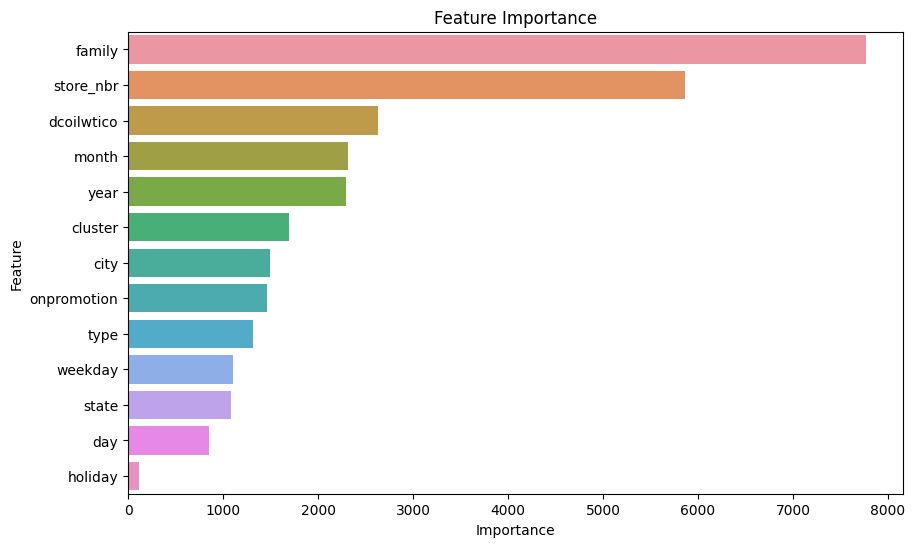

In [ ]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': lgb_model.feature_importance()})
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_names = X.columns.tolist()



plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
submission = pd.DataFrame()
submission['sales'] = test_sales
submission.to_csv('submission.csv', index=False)